Kaggle Competition: BBC News Classification 

Step 1: Extracting word features and show Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data
We will first define a class to handle csv files, implementing EDA and cleaning process.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

class DataAnalyzer:
    def __init__(self):
        self.train_data = None
        self.test_data = None


    def load_data(self, file_path, is_train=True):
        data = pd.read_csv(file_path)
        if is_train:
            self.train_data = data
        else:
            self.test_data = data
        return data
    
    @staticmethod
    def show_basic_info(data):
        print("Basic Information:")
        print(data.info())
        print("\nStatistical Summary:")
        print(data.describe())
        print("\nCategory Distribution:")
        print(data['Category'].value_counts())
    
    @staticmethod
    def plot_category_distribution(data):
        plt.figure(figsize=(10, 6))
        sns.countplot(x='Category', data=data, order=data['Category'].value_counts().index)
        plt.title('Category Distribution')
        plt.xlabel('Category')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()
        
    @staticmethod
    def plot_text_length_distribution(data, target_column='Text'):
        data['Text_Length'] = data[target_column].apply(len)
        plt.figure(figsize=(10, 6))
        sns.histplot(data['Text_Length'], bins=50, kde=True)
        plt.title('Text Length Distribution')
        plt.xlabel('Text Length')
        plt.ylabel('Frequency')
        plt.show()

    @staticmethod
    def show_word_frequencies(data, target_column='Text'):
        all_text = " ".join(data[target_column])
        words = all_text.split()
        word_counts = Counter(words)
        common_words = word_counts.most_common(20)
        
        print("\nMost Common 20 Words:")
        for word, count in common_words:
            print(f"{word}: {count}")

        wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate_from_frequencies(word_counts)
        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title('Word Cloud')
        plt.axis('off')
        plt.show()

    def perform_eda(self, data, target_column='Text'):
        self.show_basic_info(data)
        self.plot_category_distribution(data)
        self.plot_text_length_distribution(data, target_column=target_column)
        self.show_word_frequencies(data, target_column=target_column)
        

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB
None

Statistical Summary:
         ArticleId
count  1490.000000
mean   1119.696644
std     641.826283
min       2.000000
25%     565.250000
50%    1112.500000
75%    1680.750000
max    2224.000000

Category Distribution:
Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64


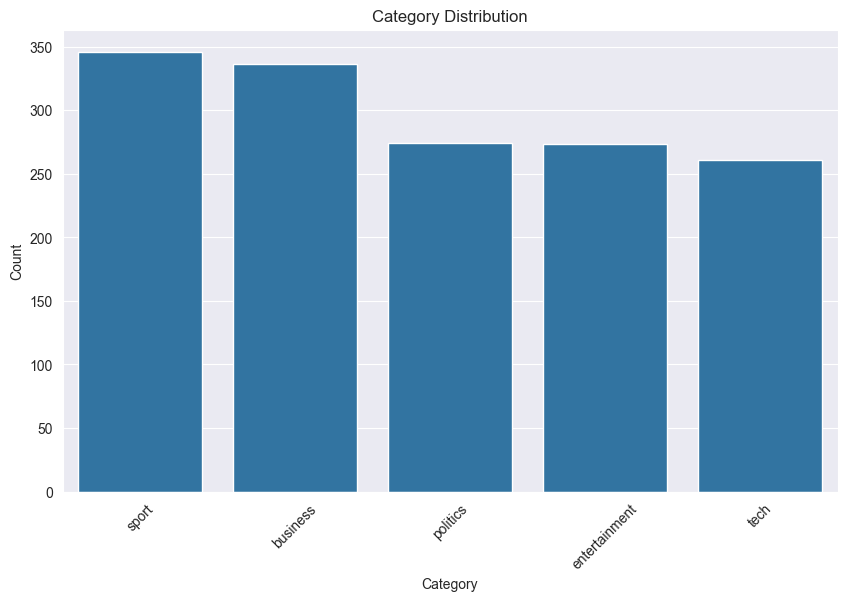

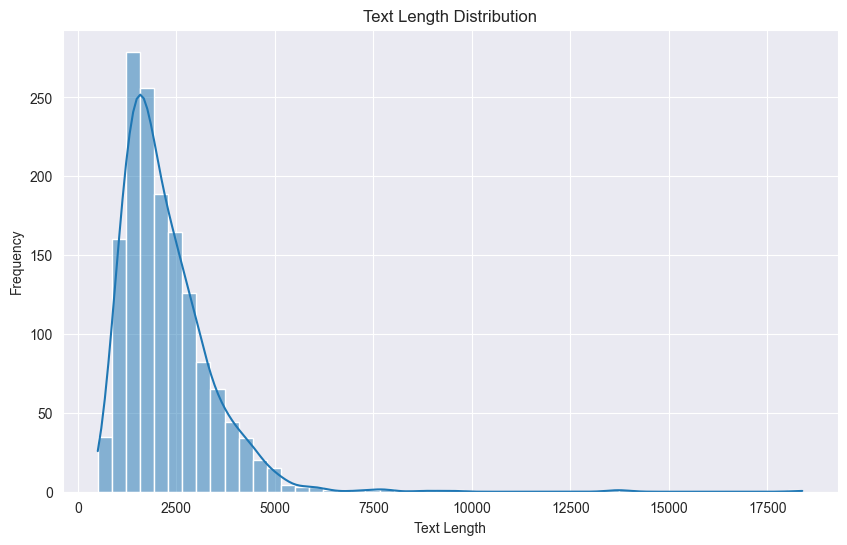


Most Common 20 Words:
the: 34992
to: 16568
of: 12970
and: 12366
a: 12102
in: 11696
s: 5899
for: 5773
is: 5478
that: 5207
it: 5000
on: 4991
was: 4019
he: 3866
be: 3803
with: 3482
said: 3401
has: 3250
as: 3245
have: 3133


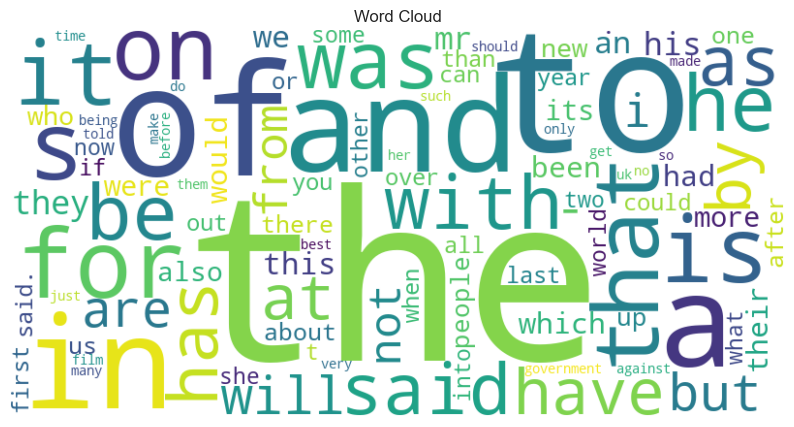

In [2]:
analyzer = DataAnalyzer()
train_data = analyzer.load_data('data/BBC News Train.csv', is_train=True)
test_data = analyzer.load_data('data/BBC News Test.csv', is_train=False)
analyzer.perform_eda(train_data)

According to the EDA above, we learn that each category has close weight to the whole data, and we learn that the text length does not distribute evenly, most of which has 1000-5000.
Besides, from the wordcloud plot, we learn that the most frequent words in English are empty words, such as 'the', 'is', 'and'. This kind of words, is called 'stop words', which means noise in text processing. Hence, removing such stop words is crucial in further implementation.
Furthermore, in English, a word may have multiple forms but with the same 'stem', which means the original form of the word. The application of lemmatization is implemented to transform word formation into the same word.


In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

class DataCleaner(DataAnalyzer):
    def __init__(self, analyzer):
        super().__init__()
        self.__dict__.update(analyzer.__dict__)
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        
    @staticmethod
    def clean_data(data):
        data_cleaned = data.dropna().drop_duplicates()
        return data_cleaned
    
    def preprocess_text(self, text):
        tokens = text.split()
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens if token.lower() not in self.stop_words]
        return " ".join(tokens)
    
    def preprocess_texts(self, data):
        data['Processed_Text'] = data['Text'].apply(self.preprocess_text)
        return data
        
    def data_process(self):
        # Clean the data
        self.train_data = self.clean_data(self.train_data)
        # Preprocess the texts
        self.train_data = self.preprocess_texts(self.train_data)
        if self.test_data is not None:
            self.test_data = self.clean_data(self.test_data)
            self.test_data = self.preprocess_texts(self.test_data)
    

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ArticleId       1490 non-null   int64 
 1   Text            1490 non-null   object
 2   Category        1490 non-null   object
 3   Text_Length     1490 non-null   int64 
 4   Processed_Text  1490 non-null   object
dtypes: int64(2), object(3)
memory usage: 58.3+ KB
None

Statistical Summary:
         ArticleId   Text_Length
count  1490.000000   1490.000000
mean   1119.696644   2233.461745
std     641.826283   1205.153358
min       2.000000    501.000000
25%     565.250000   1453.000000
50%    1112.500000   1961.000000
75%    1680.750000   2751.250000
max    2224.000000  18387.000000

Category Distribution:
Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64


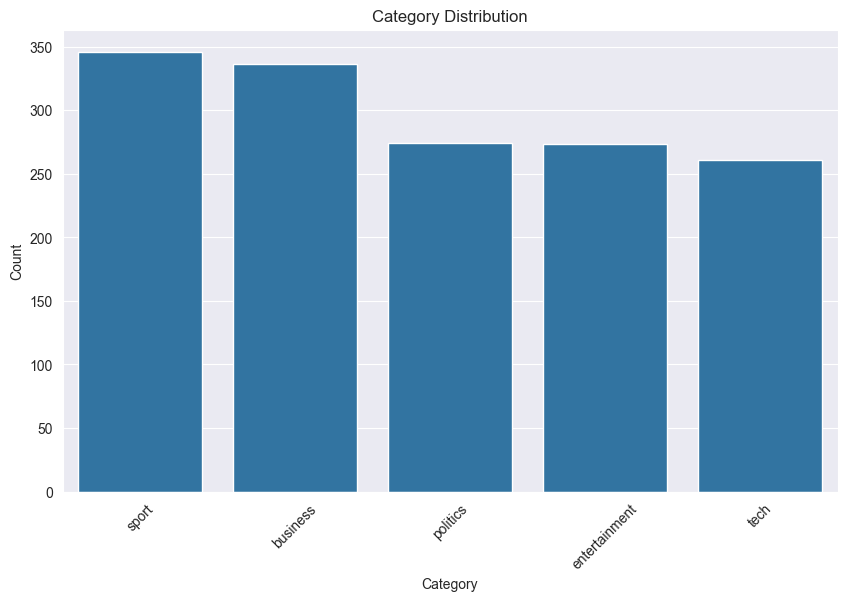

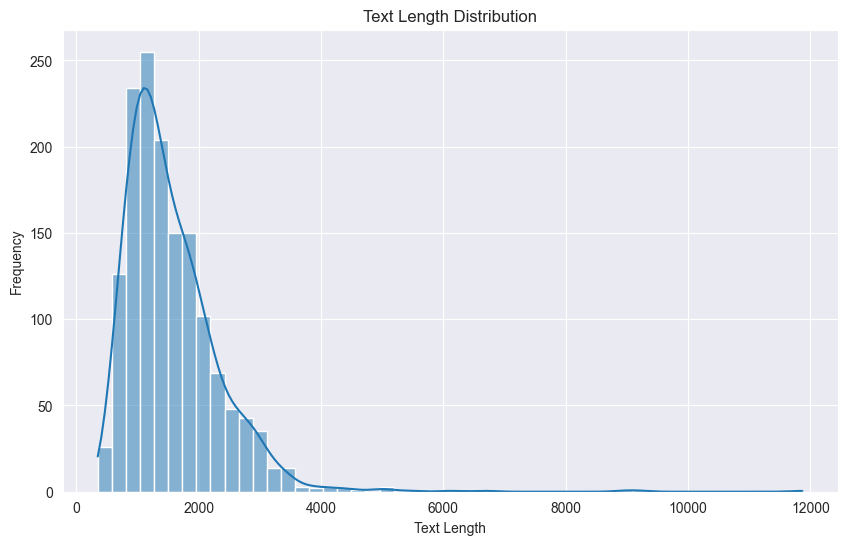


Most Common 20 Words:
said: 3401
-: 2125
mr: 2002
would: 1710
year: 1425
also: 1424
new: 1329
people: 1278
one: 1151
u: 1139
could: 1031
said.: 987
first: 890
last: 883
two: 801
game: 799
time: 795
.: 790
say: 747
world: 730


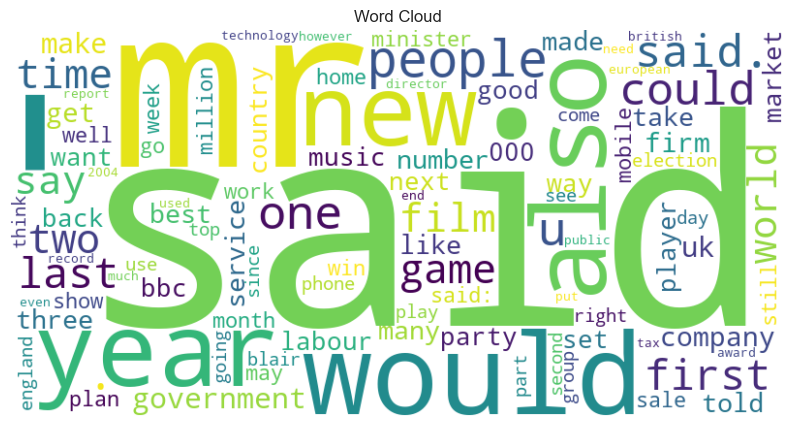

In [4]:
cleaner = DataCleaner(analyzer)
cleaner.data_process()
cleaner.perform_eda(cleaner.train_data, target_column='Processed_Text')

Based on the latest processing outcome, I realize that there are many punctuations and meaningless words (e.g. 'make') in the most frequent words, which require further filter. Besides, I notice that maybe upper and lower first letter should be unified as the same formation. I will update the preprocess_text() method of class.

In [5]:
# redefine the class DataCleaner
import string
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

class DataCleaner(DataAnalyzer):
    def __init__(self, analyzer):
        super().__init__()
        self.__dict__.update(analyzer.__dict__)
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        
    @staticmethod
    def clean_data(data):
        data_cleaned = data.dropna().drop_duplicates()
        return data_cleaned
    
    def preprocess_text(self, text):

        high_freq_words = {'said', 'mr', 'also', 'would', 'could', 'u', 'say', 'year', 'you', 'go', 'come', 'last', 'first', 'time', 'make', 'use', 'take', 'get', 'new', 'people', 'good', 'one', 'two', 'three', 'best', 'tell', 'show', 'work', 'want', 'give', 'like', 'many', 'number'}
        
        text = text.lower()
        text = text.translate(str.maketrans('', '', string.punctuation))
        tokens = word_tokenize(text)
        pos_tags = pos_tag(tokens)
        tokens = [self.lemmatizer.lemmatize(token, self.get_wordnet_pos(tag)) for token, tag in pos_tags]
        tokens = [word for word in tokens if word not in self.stop_words and word not in high_freq_words]
        return " ".join(tokens)
    
    @staticmethod
    def get_wordnet_pos(tag):
        if tag.startswith('J'):
            return wordnet.ADJ
        elif tag.startswith('V'):
            return wordnet.VERB
        elif tag.startswith('N'):
            return wordnet.NOUN
        elif tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN
        
    def preprocess_texts(self, data):
        data['Processed_Text'] = data['Text'].apply(self.preprocess_text)
        return data
        
    def data_process(self):
        self.train_data = self.clean_data(self.train_data)
        self.train_data = self.preprocess_texts(self.train_data)
        if self.test_data is not None:
            self.test_data = self.clean_data(self.test_data)
            self.test_data = self.preprocess_texts(self.test_data)
        

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ArticleId       1490 non-null   int64 
 1   Text            1490 non-null   object
 2   Category        1490 non-null   object
 3   Text_Length     1490 non-null   int64 
 4   Processed_Text  1490 non-null   object
dtypes: int64(2), object(3)
memory usage: 58.3+ KB
None

Statistical Summary:
         ArticleId   Text_Length
count  1490.000000   1490.000000
mean   1119.696644   2233.461745
std     641.826283   1205.153358
min       2.000000    501.000000
25%     565.250000   1453.000000
50%    1112.500000   1961.000000
75%    1680.750000   2751.250000
max    2224.000000  18387.000000

Category Distribution:
Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64


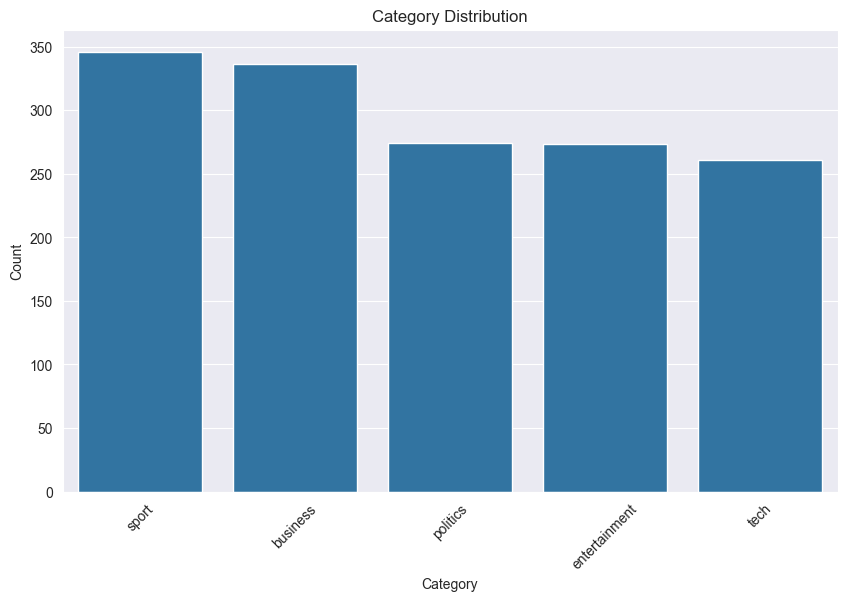

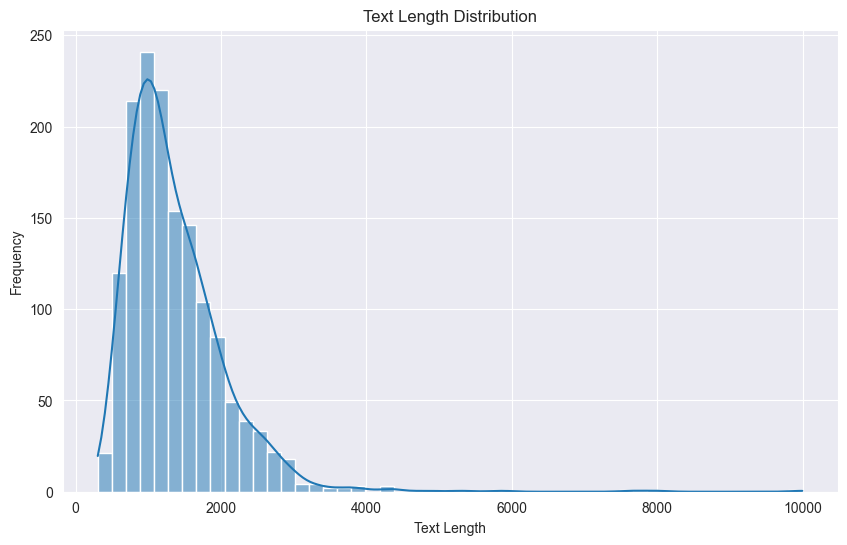


Most Common 20 Words:
win: 1023
game: 998
film: 815
world: 811
government: 771
uk: 757
play: 748
company: 682
firm: 676
see: 643
service: 617
add: 597
plan: 582
back: 581
include: 580
country: 564
market: 560
think: 560
month: 554
well: 546


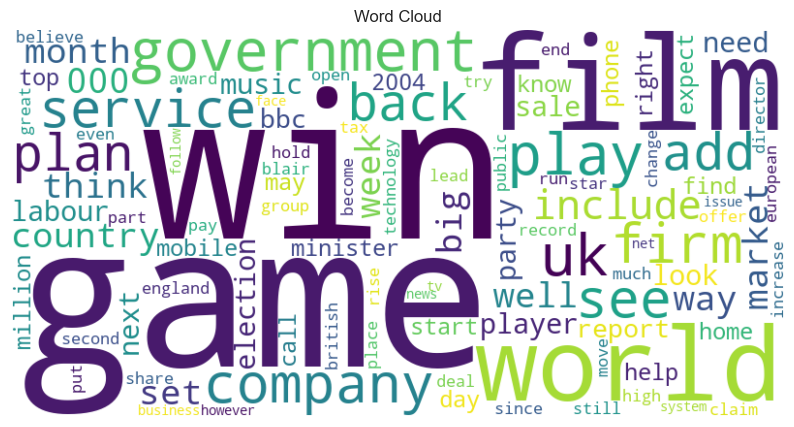

     ArticleId                                               Text  \
0         1018  qpr keeper day heads for preston queens park r...   
1         1319  software watching while you work software that...   
2         1138  d arcy injury adds to ireland woe gordon d arc...   
3          459  india s reliance family feud heats up the ongo...   
4         1020  boro suffer morrison injury blow middlesbrough...   
..         ...                                                ...   
730       1923  eu to probe alitalia  state aid  the european ...   
731        373  u2 to play at grammy awards show irish rock ba...   
732       1704  sport betting rules in spotlight a group of mp...   
733        206  alfa romeos  to get gm engines  fiat is to sto...   
734        471  citizenship event for 18s touted citizenship c...   

                                        Processed_Text  
0    qpr keeper day head preston queen park ranger ...  
1    software watch software monitor every keystrok...  


In [6]:
cleaner = DataCleaner(analyzer)
cleaner.data_process()
cleaner.perform_eda(cleaner.train_data, target_column='Processed_Text')
print(cleaner.test_data)

We may notice that the high_freq_words set need to be maintained manually, which is low efficient and mistakable. Now, I would then implement further process of feature extraction to lower the reliance on the high_freq_words set.
I learn that there are 2 main available approach of feature extraction in NLP, TF-IDF and word embedding. The first one focus on statistical feature of word frequency in each article id, and the second one focus on linguist feature of the meaning of texts.
I would like to establish two feature matrix to compare which one performs better in this problem and explore the possibility of combination of both statistical and linguist features.
First I would define a basic class.

In [41]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import copy
class FeatureExtractor:
    def __init__(self, cleaner):
        self.train_data = cleaner.train_data.copy()
        self.test_data = cleaner.test_data.copy()
        
        self.train_features = None
        self.test_features = None
        self.label_mapping = {}
        self.inverse_label_mapping = {}
        
        self.create_label_mapping()
    @staticmethod
    def visualize_features(features):
        if isinstance(features, csr_matrix):
            features = features.toarray()

        plt.figure(figsize=(10, 6))

        cmap = plt.cm.seismic

        norm = plt.Normalize(vmin=-np.max(np.abs(features)), vmax=np.max(np.abs(features)))
        plt.imshow(features, aspect='auto', interpolation='nearest', cmap=cmap, norm=norm)
        plt.colorbar()
        plt.title('Matrix Visualization')
        if features.shape[0] == 5:
            plt.xlabel('Features')
            plt.ylabel('Categories')
        elif features.shape[1] == 5:
            plt.xlabel('Categories')
            plt.ylabel('Documents')
        else:
            plt.xlabel('Features')
            plt.ylabel('Documents')
        plt.show()
                    
    def create_label_mapping(self):
        unique_labels = self.train_data['Category'].unique()
        self.label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
        self.inverse_label_mapping = {idx: label for idx, label in enumerate(unique_labels)}
        self.train_data['Category'] = self.train_data['Category'].map(self.label_mapping).astype(int)
        
    def extract_features(self):
        raise NotImplementedError("Subclasses should implement this method!")
        


In the context of feature matrices used in natural language processing (NLP), the columns represent the features extracted from the text data. The nature of these features differs significantly between two common methods: TF-IDF and word embeddings. Here’s a summary of what the columns represent in each type of feature matrix:

TF-IDF Feature Matrix
1) Individual Columns: Each column in a TF-IDF feature matrix represents a unique word from the corpus.
2) Values in Columns: The values in these columns represent the TF-IDF score of each word for a given document. This score is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus, which helps to adjust for the fact that some words appear more frequently in general.
3) Sparsity: TF-IDF matrices are typically sparse because not every word appears in every document, so many entries are zero, indicating the absence of the corresponding word in those documents.

Word Embedding Feature Matrix
1) Individual Columns: Each column in a feature matrix derived from word embeddings represents a dimension in the embedding space. Unlike TF-IDF, these dimensions do not correspond to specific, identifiable words.
2) Values in Columns: The values are continuous and represent the coordinates of the document's vector in the embedding space. These vectors are obtained by averaging (or another aggregation method) the embeddings of all the words in a document, resulting in a dense representation where each dimension reflects a composite of semantic and syntactic features learned during the training of the embeddings.
3) Dense Nature: Unlike TF-IDF, embedding matrices are dense, meaning most values are non-zero. Each dimension of the embeddings captures latent linguistic features that are not straightforward to interpret individually but collectively provide a rich, nuanced representation of text semantics.

To summarize, TF-IDF matrices are ideal for tasks where the individual importance of specific words (relative to their document and corpus-wide occurrences) is crucial. They are characterized by high dimensionality and sparsity.
Embedding matrices excel in tasks requiring an understanding of complex language patterns and relationships, supported by their dense and semantically rich nature. These matrices are particularly useful in deep learning models where contextual nuances are important. 
Let's define these two feature extraction tool.

In [44]:
import spacy
class TFIDFFeatureExtractor(FeatureExtractor):
    def __init__(self, cleaner):
        super().__init__(cleaner)
        self.extract_features()
        
    def extract_features(self):
        vectorizer = TfidfVectorizer(max_df=0.7, min_df=5, stop_words='english')
        self.train_features = vectorizer.fit_transform(self.train_data['Processed_Text']).toarray()
        self.test_features = vectorizer.transform(self.test_data['Processed_Text']).toarray()

class EmbeddingFeatureExtractor(FeatureExtractor):
    def __init__(self, cleaner):
        super().__init__(cleaner)
        self.nlp = spacy.load('en_core_web_lg')
        self.extract_features()
        
    def document_vector(self, doc):
        """Generate document vectors by averaging word vectors, handling cases where no word has a vector."""
        doc = self.nlp(doc)
        vectors = [word.vector for word in doc if not word.is_stop and word.has_vector]
        if vectors:
            return np.mean(vectors, axis=0)
        else:
            return np.zeros((300,))

    def extract_features(self):
        """Use document_vector method to create feature matrix."""
        self.train_features = np.array([self.document_vector(text) for text in self.train_data['Processed_Text']])
        self.test_features = np.array([self.document_vector(text) for text in self.test_data['Processed_Text']])

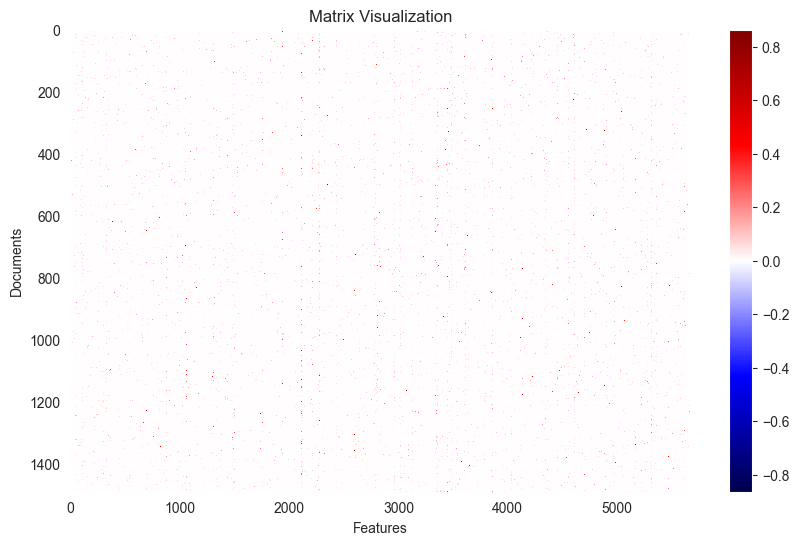

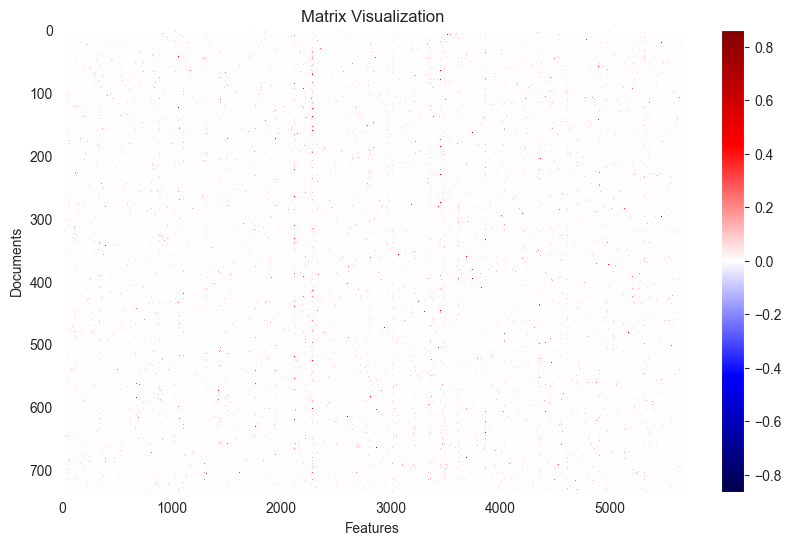

In [46]:
tfidf_extractor = TFIDFFeatureExtractor(cleaner)
tfidf_extractor.visualize_features(tfidf_extractor.train_features)
tfidf_extractor.visualize_features(tfidf_extractor.test_features)

From the visualization of the feature matrix visualization above, several key insights can be observed:

1) Sparsity: The image clearly displays the sparse nature of the matrix, with most of the points being blank (indicating zero values) and only a few points marked (indicating non-zero values). This is a typical characteristic of text data, especially when methods like word frequency or TF-IDF are used because not all words appear in every document.

2) Distribution of Data: The non-zero points are relatively dispersed, without clustering in specific areas, suggesting that no few features are universally present across all documents. This indicates a high degree of variability in how features (words) are used across different documents.

3) Feature Utilization: The distribution of non-zero points also implies that a broad range of features are utilized by some documents, although the frequency might not be high. This suggests that the feature extraction method (presumably TF-IDF) has successfully captured enough information to describe the contents of the dataset.


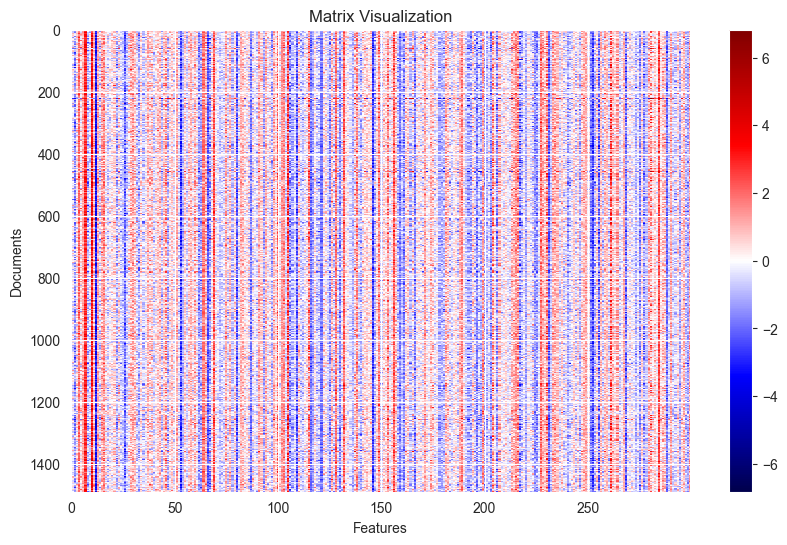

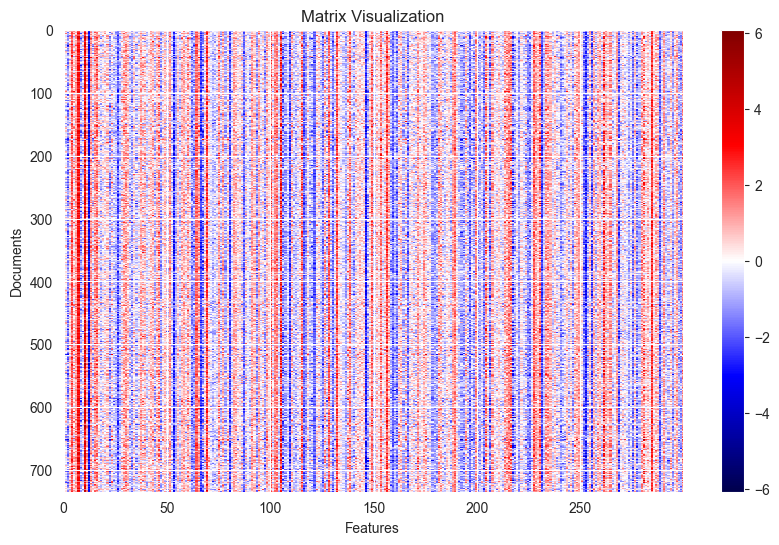

In [47]:
embedding_extractor = EmbeddingFeatureExtractor(cleaner)
embedding_extractor.visualize_features(embedding_extractor.train_features)
embedding_extractor.visualize_features(embedding_extractor.test_features)

The visualization of the feature matrix derived from the EmbeddingFeatureExtractor shows some distinct patterns and characteristics worth analyzing:

Observations from the Visualization
1) Dense Representation: Unlike the sparse matrix typically seen with TF-IDF representations, the visualization here exhibits a more densely populated feature matrix. This denseness is a characteristic of embedding-based approaches where every word is represented by a dense vector, and every document vector is an aggregation (e.g., average) of these word vectors.

2) Patterns and Uniformity: There are visible patterns and blocks of uniformity across the matrix, which could indicate groups of documents with similar thematic content or stylistic features. The uniform blocks suggest that certain segments of features (or dimensions of the embeddings) are consistently active across several documents.

3) Feature Consistency: The presence of consistent horizontal lines across many documents could imply that certain dimensions in the word vectors are frequently activated. This might be indicative of common themes or linguistic structures prevalent across the dataset.


Then, let's implement factorization to generate factorization of the W and H matrix of each type of feature extraction.

In [54]:
class Factorization:
    def __init__(self, extractor, trim_features=None):
        self.train_features = copy.deepcopy(extractor.train_features)
        self.test_features = copy.deepcopy(extractor.test_features)
        self.trim_features = trim_features
        self.label_mapping = extractor.label_mapping
        self.inverse_label_mapping = extractor.inverse_label_mapping
        self.train_data = extractor.train_data
        self.test_data = extractor.test_data
        
        self.W = None
        self.H = None
        self.model = None
        self.selector = None
        self.W_test = None
        
        if self.trim_features is not None:
            self.trim()
        self.SVD_fit(self.train_features)
        self.process_test_data()

    def trim(self):
        if self.train_features.shape[1] > self.trim_features:
            self.selector = SelectKBest(f_classif, k=self.trim_features)
            self.train_features = self.selector.fit_transform(self.train_features, self.train_data['Category'])

    def process_test_data(self):
        if self.trim_features:
            self.test_features = self.selector.transform(self.test_features)
        self.W_test = self.model.transform(self.test_features)

    def SVD_fit(self, features, n_components=5):
        self.model = TruncatedSVD(n_components=n_components)
        self.W = self.model.fit_transform(features)
        self.H = self.model.components_

Matrix W1 (document-topic weights): (1490, 5)
Matrix H1 (topic-feature weights): (5, 5669)


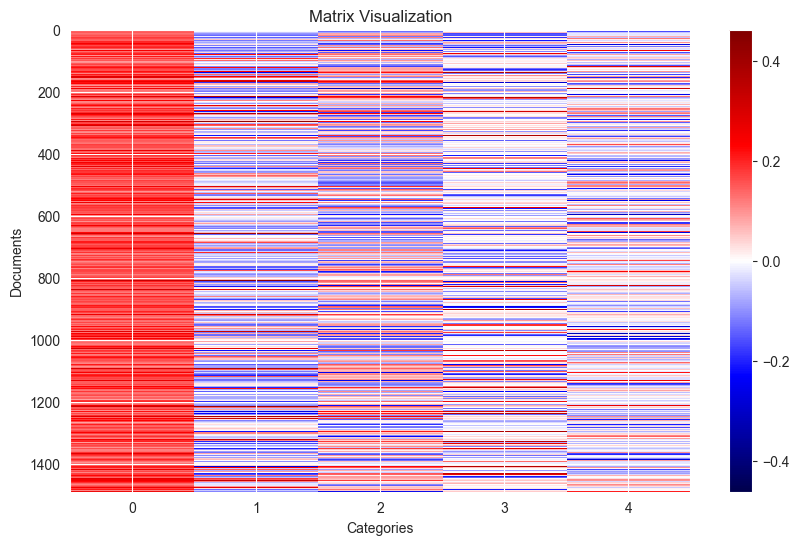

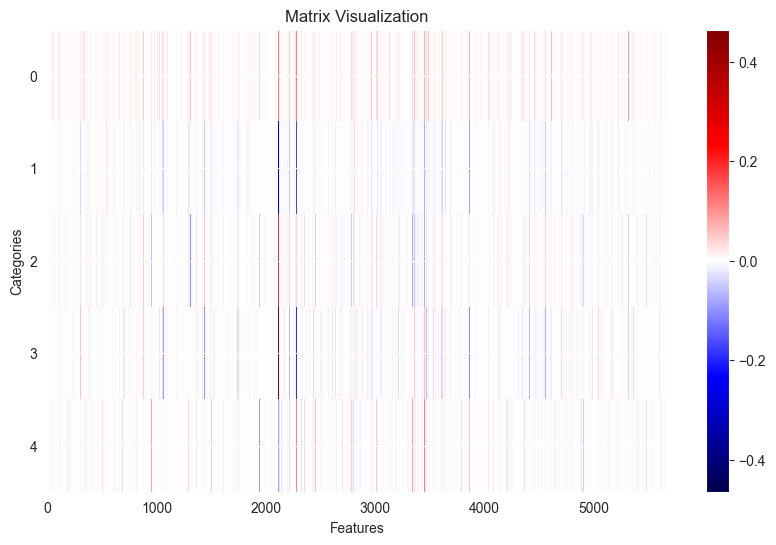

In [55]:
tfidf_factor = Factorization(tfidf_extractor)
print("Matrix W1 (document-topic weights):", tfidf_factor.W.shape)
print("Matrix H1 (topic-feature weights):", tfidf_factor.H.shape)
tfidf_extractor.visualize_features(tfidf_factor.W)
tfidf_extractor.visualize_features(tfidf_factor.H)

Matrix W2 (document-topic weights): (1490, 5)
Matrix H2 (topic-feature weights): (5, 300)


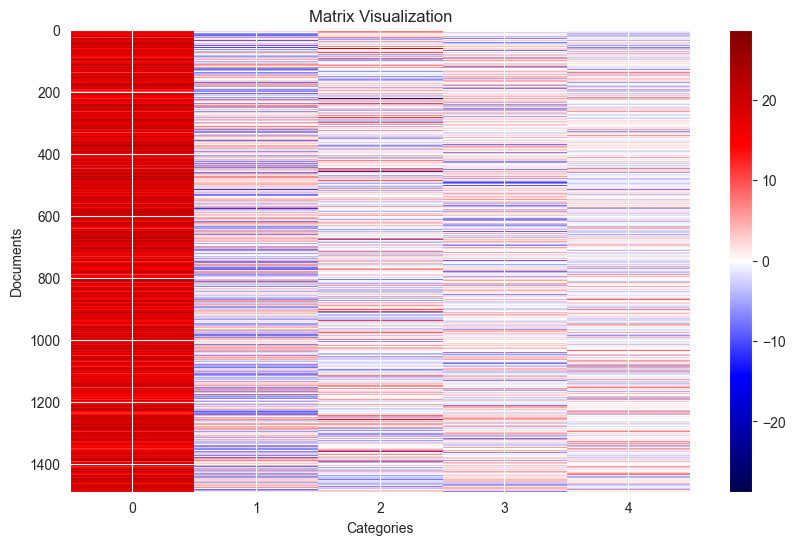

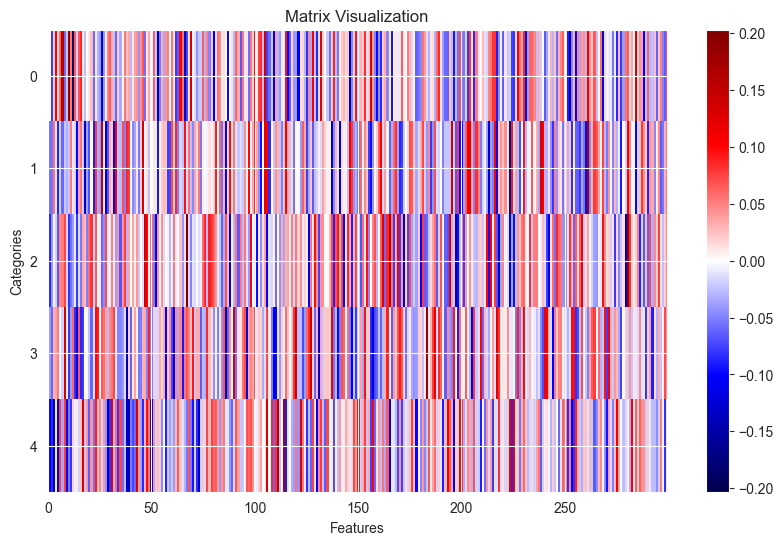

In [56]:
embedding_factor = Factorization(embedding_extractor)
print("Matrix W2 (document-topic weights):", embedding_factor.W.shape)
print("Matrix H2 (topic-feature weights):", embedding_factor.H.shape)
embedding_extractor.visualize_features(embedding_factor.W)
embedding_extractor.visualize_features(embedding_factor.H)

In the visualizations of the Singular Value Decomposition (SVD) applied to matrices generated from word embeddings and TF-IDF, we can observe unique characteristics in the resultant matrices W (document-topic weights) and H (topic-feature weights):

Comparison of Results from TF-IDF and Word Embedding SVD
Intensity and Uniformity:

TF-IDF: The W matrix often exhibits more variation in the strength of document-topic associations across different topics, which can provide valuable insights for identifying dominant themes in documents. The H matrix from TF-IDF tends to show sparsity, highlighting the distinct contributions of specific terms to the topics.
Embeddings: Conversely, the embedding-based W matrix tends to display more uniformity, especially notable in the intense association of all documents with the first feature, potentially offering less granularity in distinguishing between different thematic structures. The H matrix is denser, showing a rich pattern of positive and negative associations, indicating a nuanced interplay of features that captures both semantic and syntactic nuances.

Implications

Interpretability: TF-IDF matrices are often easier to interpret since each feature directly correlates to a term whose significance is straightforward to understand within a topic context. In contrast, the matrices derived from embeddings require deeper analysis to interpret, as the features represent complex, abstract dimensions of the data.
Applicability: Choosing between TF-IDF and embeddings for conducting SVD should be influenced by the specific requirements of the analysis or application. TF-IDF may be more suitable for applications that demand direct interpretability and identification of key terms. In contrast, embeddings might be favored for applications that require a comprehensive understanding of text based on underlying semantic and syntactic patterns.

After the feature extraction process and the outcome of W and H matrix of the two type of feature matrix, I then implement step 2 of building and training models.

 W here is the low dimensionality form of the features, with the shape of sample_num * category_num (1490,5), and is suitable to implement some unsupervised approach like Kmeans to cluster into 5 category. We can find the best mateched mapping relationship of the cluster labels and real labels of each prediction. After this, we can predict test text by extract them into features and their W matrix and then predict by searching which cluster center of certain test text close to and label it.
 
Step 2: Building and training models

I would like to answer the first question of guidance:
1.Think about this and answer: when you train the unsupervised model for matrix factorization, should you include texts (word features) from the test dataset or not as the input matrix? Why or why not?
Answer: Obviously, we should not include texts from test dataset as the input matrix to ensure the independence and generalizability of the model evaluation. Because if we include the testing data, the independence of testing data will be broken, and thus the result of our model would be not reliable.

Next, I would follow the guidance to 
2.build a model using the matrix factorization method(s),
3.measure the performances on predictions from both train and test datasets.


In [73]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from kaggle.api.kaggle_api_extended import KaggleApi

class ModelTrainer:
    def __init__(self, feature_factor):
        self.train_features = feature_factor.train_features
        
        self.W = feature_factor.W
        self.H = feature_factor.H
        self.W_test = feature_factor.W_test
        
        self.label_mapping = feature_factor.label_mapping
        self.inverse_label_mapping = feature_factor.inverse_label_mapping
        self.true_labels = feature_factor.train_data['Category']
        
        self.train_data = feature_factor.train_data
        self.test_data = feature_factor.test_data
        
        self.cluster_model = None
        self.performance_log = []
        self.mapping = None
        self.accuracy = None
        self.test_pred = None
        self.train_pred = None
        
    def train_model(self, plot=False):
        self.cluster_model = KMeans(n_clusters=5, random_state=42)
        self.cluster_model.fit(self.W)

        predicted_labels_train = self.cluster_model.labels_
        self.mapping, mapped_labels, self.accuracy = self.find_best_label_mapping(self.true_labels, predicted_labels_train)
        self.train_pred = [self.inverse_label_mapping[label] for label in mapped_labels]
        
        if plot:
            self.plot_confusion_matrix(confusion_matrix(self.true_labels, mapped_labels), np.unique(self.true_labels))
            print(f'accuracy is {self.accuracy}')

    def predict_test_data(self):
        predicted_labels_test = self.cluster_model.predict(self.W_test)
        
        mapped_labels_test = [self.mapping[label] for label in predicted_labels_test]
        predicted_categories = [self.inverse_label_mapping[label] for label in mapped_labels_test]

        self.test_pred = pd.DataFrame({
            'ArticleId': self.test_data['ArticleId'],
            'Category': predicted_categories
        })
    
    @staticmethod
    def find_best_label_mapping(true_labels, predicted_labels):
        from itertools import permutations
        unique_labels = np.unique(true_labels)
        best_mapping = None
        best_accuracy = 0
        best_mapped_labels = None

        for perm in permutations(unique_labels):
            label_mapping = {i: perm[i] for i in range(len(unique_labels))}
            mapped_labels = [label_mapping[label] for label in predicted_labels]
            accuracy = accuracy_score(true_labels, mapped_labels)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_mapping = label_mapping
                best_mapped_labels = mapped_labels

        return best_mapping, best_mapped_labels, best_accuracy
    
    @staticmethod
    def plot_confusion_matrix(cm, labels):
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()
        
    @staticmethod
    def submit_to_kaggle(res, competition, filename, message):
        submission = res
        submission.to_csv(filename, index=False)
        api = KaggleApi()
        api.authenticate()
        api.competition_submit(file_name=filename, competition=competition, message=message)
        
    @staticmethod
    def plot_performance_log(num_features, accuracies):
        plt.figure(figsize=(10, 7))
        plt.plot(num_features, accuracies, marker='o')
        plt.xlabel('Number of Features')
        plt.ylabel('Accuracy')
        plt.title('Performance Across Different Number of Features')
        plt.grid(True)
        plt.show()
        
    @staticmethod
    def hyperparameter_tuning(features_list, extractor):
        import gc
        best_trainer = None
        best_accuracy = 0
        accuracies = []
        best_num = 0
        test_pred = []
        train_pred = []
        for num in features_list:
            trainer = ModelTrainer(Factorization(extractor, trim_features=num))
            trainer.train_model()
            accuracy = trainer.accuracy
            accuracies.append(accuracy)
            
            trainer.predict_test_data()
            #trainer.submit_to_kaggle('learn-ai-bbc', 'submission.csv', 'Message')
            test_pred.append(trainer.test_pred)
            train_pred.append(trainer.train_pred)
            if best_accuracy < accuracy:
                best_trainer = trainer
                best_num = num
                best_accuracy = accuracy
            else:
                del trainer

            gc.collect()
            
        ModelTrainer.plot_performance_log(features_list,accuracies)
        print(f'The best trainer has {best_num} hyperparameters, with accuracy of {best_accuracy}')
        return best_trainer, best_accuracy, best_num, accuracies, test_pred, train_pred

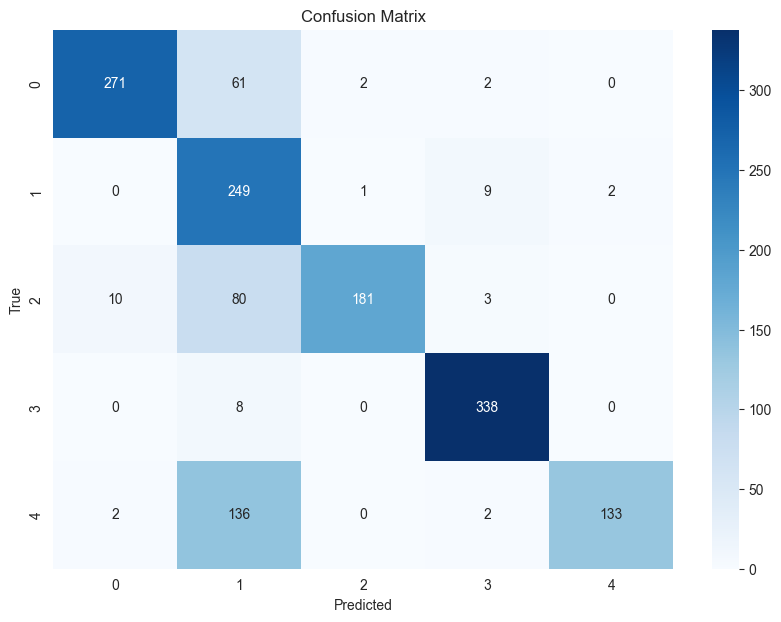

accuracy is 0.7865771812080536


In [61]:
tfidf_trainer = ModelTrainer(tfidf_factor)
tfidf_trainer.train_model(plot=True)
tfidf_trainer.predict_test_data()
#trainer.submit_to_kaggle(tfidf_trainer.test_pred, 'learn-ai-bbc', 'submission.csv', 'Message')

The submission above scored 0.78367 according to the website of kaggle, which is close to the performance of training data.

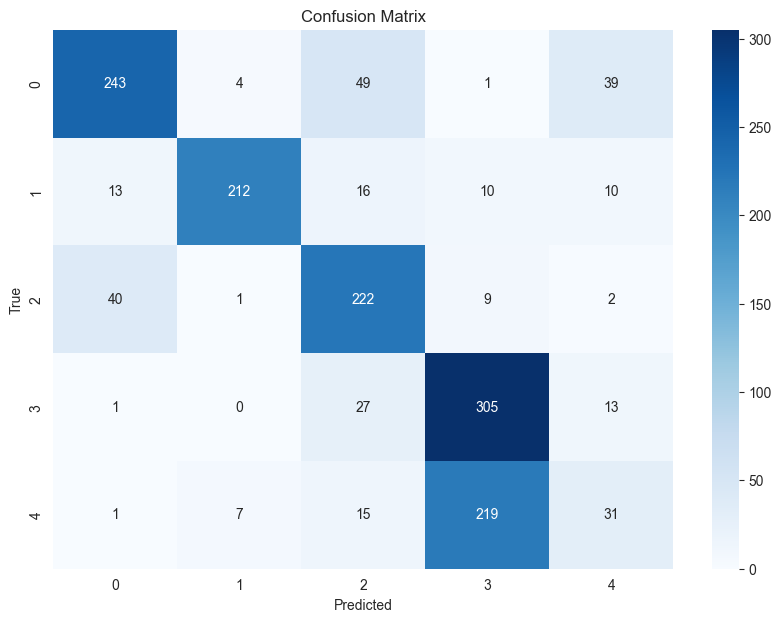

accuracy is 0.6798657718120805


In [62]:
embedding_trainer = ModelTrainer(embedding_factor)
embedding_trainer.train_model(plot=True)
embedding_trainer.predict_test_data()
#embedding_trainer.submit_to_kaggle(tfidf_trainer.test_pred, 'learn-ai-bbc', 'submission.csv', 'Message')

The submission above scored 0.68843 according to the website of kaggle, which is close to the performance of training data.

Let me compare the two matrix:

The TF-IDF model outperforms the word embedding model in terms of both training and test set accuracy. The confusion matrices show that the TF-IDF model makes fewer misclassifications across different categories. This is likely due to the high-dimensional feature space provided by TF-IDF, which captures more specific information about word frequencies and their relevance in the context of the articles.

The word embedding model, while capturing semantic information and providing a more compact representation (300 features), does not achieve the same level of accuracy as the TF-IDF model. This might be due to the fact that the embedding dimensions, though capturing semantic relationships, do not sufficiently capture the nuances of word usage frequency and importance in distinguishing between news categories.

For the task of news article classification, the TF-IDF model with 5000 features demonstrates superior performance compared to the word embedding model with 300 features. The higher accuracy and better performance in the confusion matrix indicate that TF-IDF is more effective for this particular classification task.

To further improve model performance, consider the following steps, mapping to the guidance 4) and 5):
1) Tune Hyperparameters: Change the number of features selected and the number of components in matrix factorization to find the optimal combination, by calling hyperparameter_tuning(), which apply kbest selection.
2) Ensemble Methods: Combine TF-IDF and word embedding features to build a stronger ensemble model, leveraging the strengths of both methods.


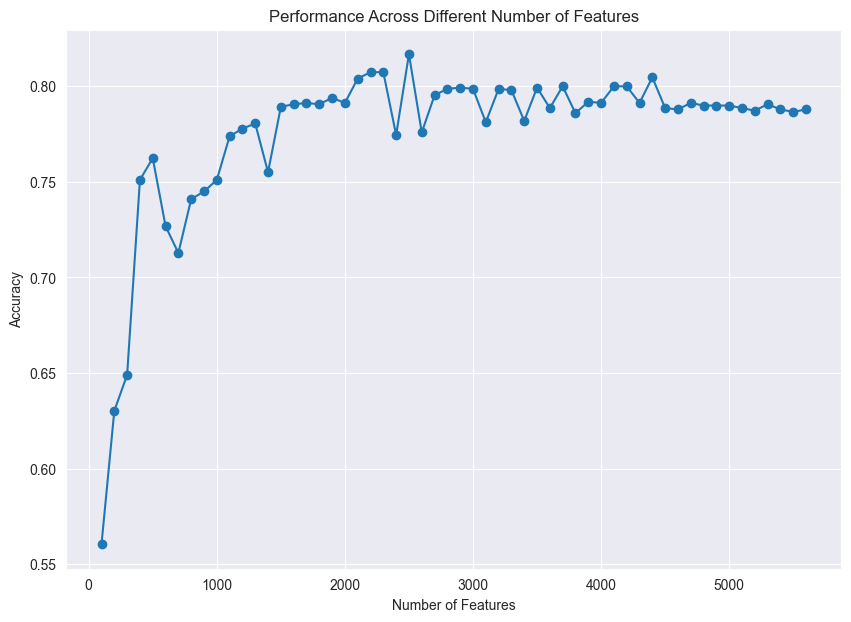

The best trainer has 2500 hyperparameters, with accuracy of 0.8167785234899329


In [63]:
# Hyperparameter tuning
best_tfidf_trainer, best_tfidf_accuracy, best_tfidf_num, tfidf_accuracies, tfidf_test_pred, tfidf_train_pred= ModelTrainer.hyperparameter_tuning([100*i for i in range(56,0,-1)], tfidf_extractor)


In [64]:
best_tfidf_trainer.submit_to_kaggle(best_tfidf_trainer.result, 'learn-ai-bbc', 'submission.csv', 'Message')

100%|██████████| 9.50k/9.50k [00:01<00:00, 6.62kB/s]


The result of best tf-idf model of predicting test data is 0.8194 accuracy, which is close to its performance on training data.

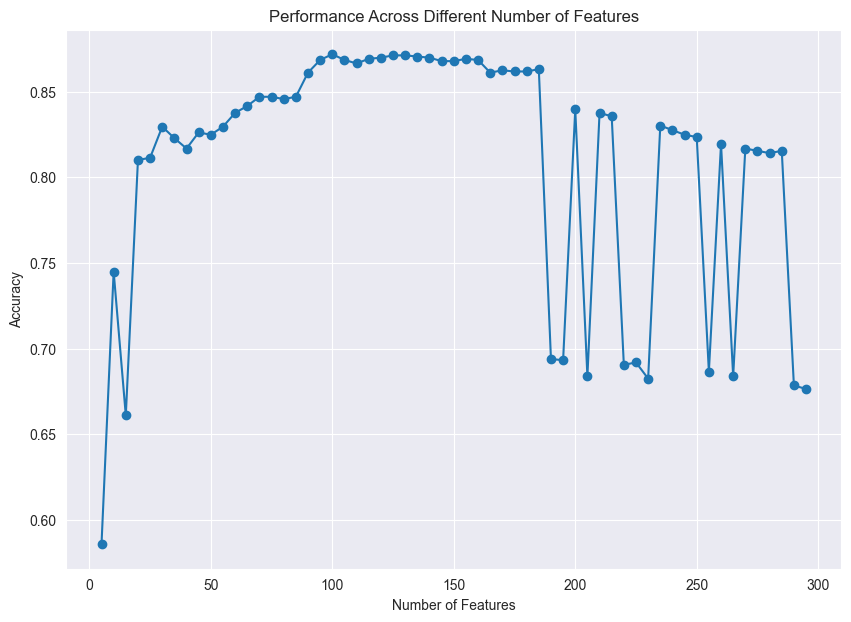

The best trainer has 100 hyperparameters, with accuracy of 0.8718120805369127


In [66]:
# Hyperparameter tuning
best_embedding_trainer, best_embedding_accuracy, best_embedding_num, embedding_accuracies, embedding_test_pred, embedding_train_pred= ModelTrainer.hyperparameter_tuning([5*i for i in range(59,0,-1)], embedding_extractor)

In [67]:
best_embedding_trainer.submit_to_kaggle(best_embedding_trainer.result, 'learn-ai-bbc', 'submission.csv', 'Message')

100%|██████████| 9.98k/9.98k [00:01<00:00, 9.84kB/s]


The performance of the best embedding model of predicting test data is of 0.84897 accuracy, which is close to its performance on training data.

From the hyperparameter tuning results, we observe that the TF-IDF model maintains stable performance as the number of features increases, while the word embedding model shows significant fluctuations. Here are the key points of the analysis:

1) Sparsity and High-Dimensional Data Handling: The TF-IDF feature matrix is highly sparse. This sparsity helps in avoiding overfitting, as the features are largely independent, with most values being zero. This makes the model robust even with a high number of features.

2) Information Distribution: The TF-IDF method selects features based on term frequency and inverse document frequency, which captures useful information while filtering out irrelevant features. This allows the model to leverage more features without introducing noise.

3) Dimensionality Control: Feature selection in TF-IDF prioritizes the most informative features, reducing the impact of unimportant ones. This helps in maintaining stable performance as the feature count increases.

4) Data Representativeness: TF-IDF effectively utilizes the distribution of terms in the data. Even with an increased number of features, it captures representative features, leading to stable model performance.

5) Word Embedding Model Issues: The word embedding model uses dense vectors for features. As the number of features increases, it may introduce noise and redundant information, causing performance fluctuations.The complexity of the word embedding model increases with more features, making it prone to overfitting in high-dimensional space.The selection of features in word embeddings is based on semantic information, which can sometimes include irrelevant features for classification tasks.

Optimal Hyperparameters
TF-IDF Model:
Based on the performance trend, the TF-IDF model achieves stable high accuracy at around 3000 to 3500 features. This range shows a balance between capturing sufficient information and avoiding overfitting.
Word Embedding Model:
For the word embedding model, the optimal number of features appears to be around 100 to 150. Beyond this range, the model's performance starts to fluctuate significantly, indicating potential overfitting or the introduction of noise.

In [74]:
import pandas as pd
from collections import Counter
import numpy as np

class EnsembleTrainer:
    def __init__(self, model_accuracies, train_predictions, train_labels, test_predictions):
        self.model_accuracies = model_accuracies
        self.train_predictions = train_predictions
        self.train_labels = train_labels
        self.test_predictions = test_predictions
        self.articleId = test_predictions[0]['ArticleId']
        self.predictions = None
        
    def weighted_vote(self, predictions):
        vote_count = Counter()
        for i, pred in enumerate(predictions):
            vote_count[pred] += self.model_accuracies[i]
        return vote_count.most_common(1)[0][0]

    def evaluate_ensemble(self):
        correct = 0
        total = len(self.train_labels)
        result = []
        for i in range(total):
            preds = [pred[i] for pred in self.train_predictions]
            voted_pred = self.weighted_vote(preds)
            result.append(voted_pred)
            if voted_pred == self.train_labels[i]:
                correct += 1
            
        ModelTrainer.plot_confusion_matrix(confusion_matrix(self.train_labels, result), np.unique(self.train_labels))
        return correct / total

    def predict_test(self):
        ensemble_predictions = []
        test_preds = [df['Category'].tolist() for df in self.test_predictions]
        num_samples = len(self.articleId)
        for i in range(num_samples):
            preds = [pred[i] for pred in test_preds]
            ensemble_predictions.append(self.weighted_vote(preds))

        self.predictions = pd.DataFrame({
            'ArticleId': self.articleId,
            'Category': ensemble_predictions
        })
    

Let us ensemble the model above, combining both two type of models, and calculate their prediction by voting according to accuracy value.

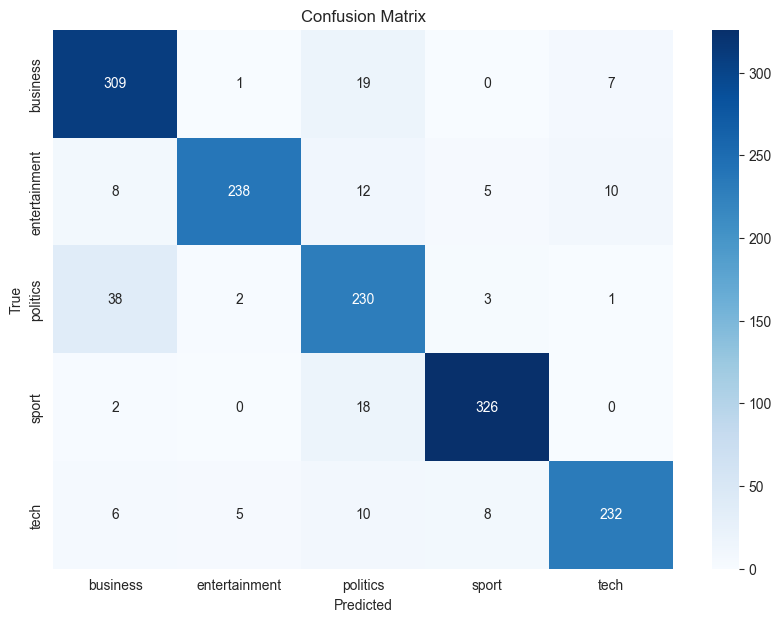

Ensemble Model Training Accuracy: 0.8959731543624161


100%|██████████| 9.92k/9.92k [00:01<00:00, 8.02kB/s]


In [75]:
ensemble_trainer = EnsembleTrainer(
    model_accuracies=tfidf_accuracies+embedding_accuracies,
    train_predictions=tfidf_train_pred+embedding_train_pred,
    train_labels=cleaner.train_data['Category'],
    test_predictions=tfidf_test_pred+embedding_test_pred,
)

ensemble_accuracy = ensemble_trainer.evaluate_ensemble()
print("Ensemble Model Training Accuracy:", ensemble_accuracy)
ensemble_trainer.predict_test()
ModelTrainer.submit_to_kaggle(ensemble_trainer.predictions, 'learn-ai-bbc', 'submission.csv', 'Message')

The performance of ensemble model is of 0.88027 accuracy, which is the best of currently explored trials.

Let's delve into Step 3, involving:
1) Pick and train a supervised learning method(s) and compare the results (train and test performance)
2) Discuss comparison with the unsupervised approach. You may try changing the train data size (e.g., Include only 10%, 20%, 50% of labels, and observe train/test performance changes). Which methods are data-efficient (require a smaller amount of data to achieve similar results)? What about overfitting?

By passing extractors which stored extracted features in previous steps, I train (fit) and predict (transform) by using supervised model of SVM.

In [87]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score

class SVMClassifier:
    def __init__(self, extractor):
        self.extractor = extractor
        self.model = SVC(kernel='linear', C=1.0, random_state=42) 

    def train(self):
        self.model.fit(self.extractor.train_features, self.extractor.train_data['Category'])

    def predict(self):
        test_predictions = self.model.predict(self.extractor.test_features)
        
        return [self.extractor.inverse_label_mapping[label] for label in test_predictions]

    def evaluate(self, plot=True):
        train_predictions = self.model.predict(self.extractor.train_features)
        cm = confusion_matrix(self.extractor.train_data['Category'], train_predictions)
        accuracy = accuracy_score(self.extractor.train_data['Category'], train_predictions)
        if plot:
            print("Training Accuracy:", accuracy)
            ModelTrainer.plot_confusion_matrix(cm, list(self.extractor.label_mapping.values()))
        return cm, accuracy

    def submit_to_kaggle(self, competition, filename, message):
        predicted_categories = self.predict()
        results_df = pd.DataFrame({
            'ArticleId': self.extractor.test_data['ArticleId'],
            'Category': predicted_categories
        })

        ModelTrainer.submit_to_kaggle(results_df, competition, filename, message)


Training Accuracy: 0.9993288590604027


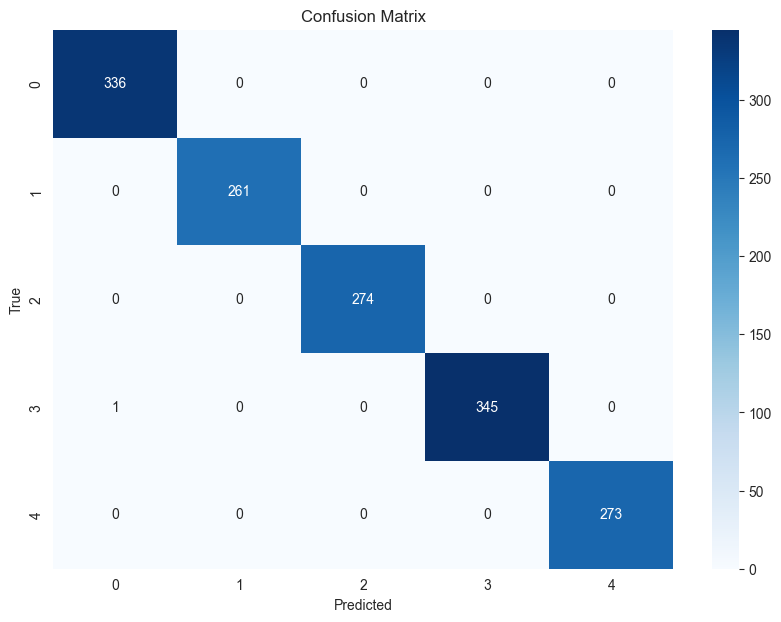

100%|██████████| 9.95k/9.95k [00:01<00:00, 7.84kB/s]


In [82]:
# Try tfidf_extractor
svm_tfidf_classifier = SVMClassifier(tfidf_extractor)
svm_tfidf_classifier.train()
svm_tfidf_classifier.evaluate()
svm_tfidf_classifier.submit_to_kaggle('learn-ai-bbc', 'submission.csv', 'Message')

The accuracy of combination of tf-idf feature extractor and svm is 0.98231, which is much higher than unsupervised learning model.

Training Accuracy: 1.0


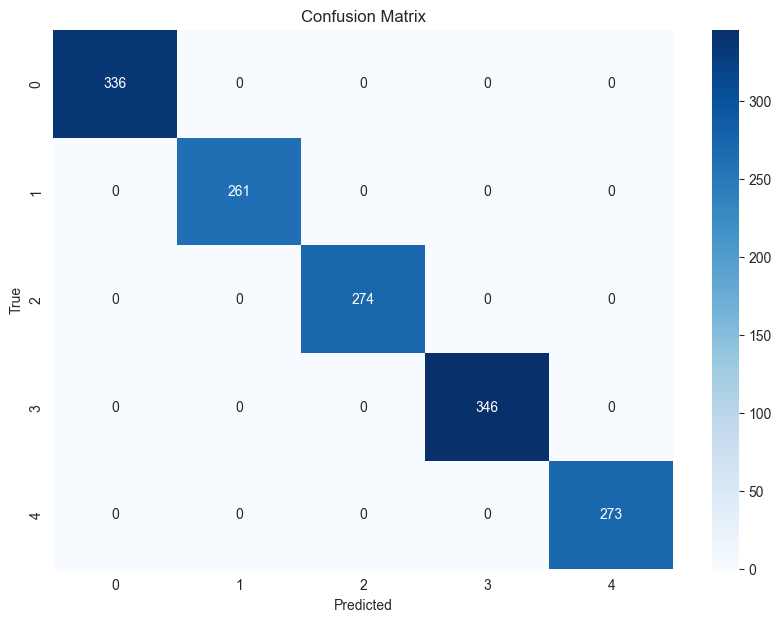

100%|██████████| 9.91k/9.91k [00:01<00:00, 9.38kB/s]


In [83]:
# Try embedding_extractor
svm_tfidf_classifier = SVMClassifier(embedding_extractor)
svm_tfidf_classifier.train()
svm_tfidf_classifier.evaluate()
svm_tfidf_classifier.submit_to_kaggle('learn-ai-bbc', 'submission.csv', 'Message')

The accuracy of combination of tf-idf feature extractor and svm is 0.97006, which is nearly the same performance of tfidf_classifier.
Next, I am going to discuss comparison with the unsupervised approach by changing the train data size (e.g., Include only 10%, 20%, 50% of labels, and observe train/test performance changes)

In [84]:
import pandas as pd
import numpy as np
from copy import deepcopy

class DataSampler:
    def __init__(self, cleaner):
        self.cleaner = deepcopy(cleaner)

    def sample_train_data(self, percentage):
        if not (0 < percentage <= 100):
            raise ValueError("Percentage must be between 0 and 100")

        # Calculate the number of samples per category to retain
        total_samples_per_category = int((len(self.cleaner.train_data) * (percentage / 100)) / len(self.cleaner.train_data['Category'].unique()))
        
        # Sample the data
        sampled_data = self.cleaner.train_data.groupby('Category').apply(lambda x: x.sample(n=min(total_samples_per_category, len(x)))).reset_index(drop=True)
        self.cleaner.train_data = sampled_data

        return self.cleaner


In [85]:
import matplotlib.pyplot as plt

class ModelPerformanceTracker:
    def __init__(self):
        self.accuracies = {
            'TFIDF_Unsupervised': [],
            'Embedding_Unsupervised': [],
            'SVM_TFIDF': [],
            'SVM_Embedding': []
        }
        self.percentages = []

    def record_accuracy(self, percentage, tfidf_unsup_acc, emb_unsup_acc, svm_tfidf_acc, svm_emb_acc):
        self.percentages.append(percentage)
        self.accuracies['TFIDF_Unsupervised'].append(tfidf_unsup_acc)
        self.accuracies['Embedding_Unsupervised'].append(emb_unsup_acc)
        self.accuracies['SVM_TFIDF'].append(svm_tfidf_acc)
        self.accuracies['SVM_Embedding'].append(svm_emb_acc)

    def plot_accuracies(self):
        plt.figure(figsize=(10, 6))
        for model_name, acc_list in self.accuracies.items():
            plt.plot(self.percentages, acc_list, marker='o', label=model_name)
        
        plt.title('Model Performance Comparison at Different Training Data Sizes')
        plt.xlabel('Percentage of Training Data Used')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_12068\4266873552.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = self.cleaner.train_data.groupby('Category').apply(lambda x: x.sample(n=min(total_samples_per_category, len(x)))).reset_index(drop=True)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_12068\4266873552.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = 

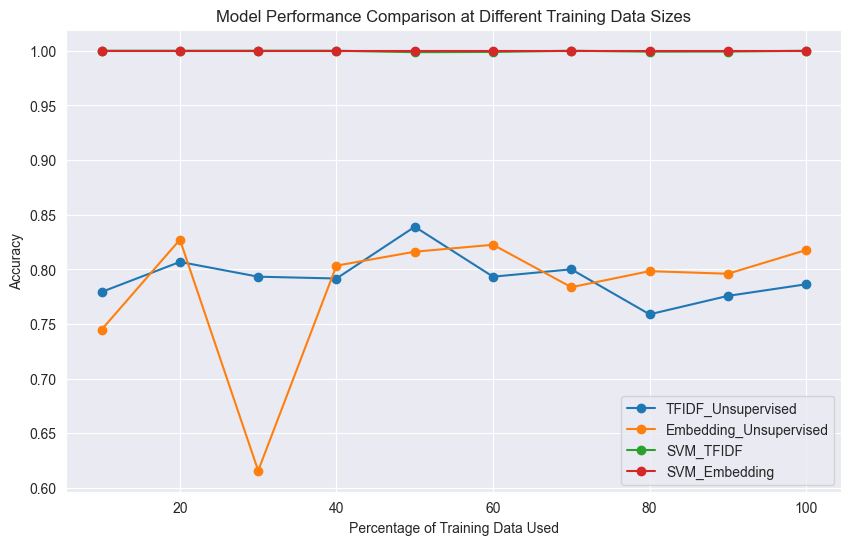

In [89]:
tracker = ModelPerformanceTracker()

percentages = [100-10*i for i in range(10)]

for percentage in percentages:
    sampler = DataSampler(cleaner)
    sampled_cleaner = sampler.sample_train_data(percentage)

    tfidf_extractor = TFIDFFeatureExtractor(sampled_cleaner)
    embedding_extractor = EmbeddingFeatureExtractor(sampled_cleaner)

    # Unsupervised 
    tfidf_factor = Factorization(tfidf_extractor)
    tfidf_trainer = ModelTrainer(tfidf_factor)
    tfidf_trainer.train_model(plot=False)

    embedding_factor = Factorization(embedding_extractor)
    embedding_trainer = ModelTrainer(embedding_factor)
    embedding_trainer.train_model(plot=False)

    # SVM
    svm_tfidf_classifier = SVMClassifier(tfidf_extractor)
    svm_tfidf_classifier.train()
    _, svm_tfidf_accuracy = svm_tfidf_classifier.evaluate(plot=False)

    svm_embedding_classifier = SVMClassifier(embedding_extractor)
    svm_embedding_classifier.train()
    _, svm_embedding_accuracy = svm_embedding_classifier.evaluate(plot=False)

    tracker.record_accuracy(percentage, tfidf_trainer.accuracy, embedding_trainer.accuracy, svm_tfidf_accuracy, svm_embedding_accuracy)

tracker.plot_accuracies()

The unsupervised model seems instable when the data is low. However, as for SVM, it seems no matter how many percentage of training data, the SVM model performance is nearly 100%, which may indicate overfitting. Let me try to submit a low performance of data to predict testing data of SVM model.

C:\Users\Administrator\AppData\Local\Temp\ipykernel_12068\4266873552.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = self.cleaner.train_data.groupby('Category').apply(lambda x: x.sample(n=min(total_samples_per_category, len(x)))).reset_index(drop=True)


Training Accuracy: 1.0


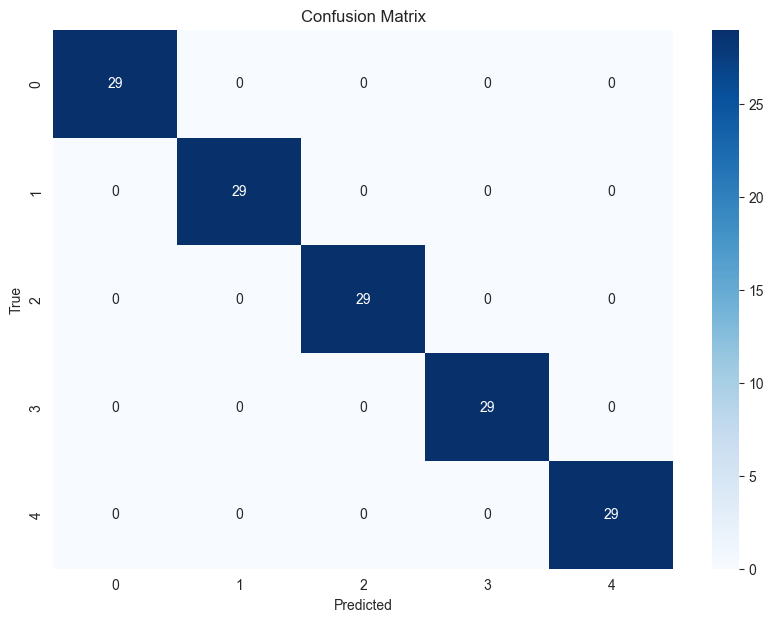

100%|██████████| 10.0k/10.0k [00:01<00:00, 8.07kB/s]


Training Accuracy: 1.0


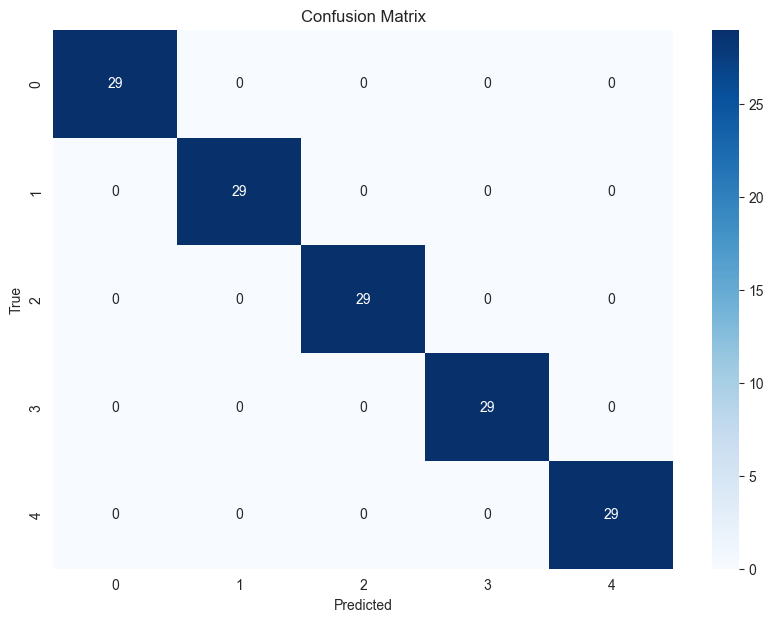

100%|██████████| 9.95k/9.95k [00:01<00:00, 9.15kB/s]


In [100]:
sampler = DataSampler(cleaner)
sampled_cleaner = sampler.sample_train_data(10)

tfidf_extractor = TFIDFFeatureExtractor(sampled_cleaner)
embedding_extractor = EmbeddingFeatureExtractor(sampled_cleaner)

svm_tfidf_classifier = SVMClassifier(tfidf_extractor)
svm_tfidf_classifier.train()
_, svm_tfidf_accuracy = svm_tfidf_classifier.evaluate(plot=True)
svm_tfidf_classifier.predict()
svm_tfidf_classifier.submit_to_kaggle('learn-ai-bbc', 'submission.csv', 'Message')

svm_embedding_classifier = SVMClassifier(embedding_extractor)
svm_embedding_classifier.train()
_, svm_embedding_accuracy = svm_embedding_classifier.evaluate(plot=True)
svm_embedding_classifier.predict()
svm_embedding_classifier.submit_to_kaggle('learn-ai-bbc', 'submission.csv', 'Message')


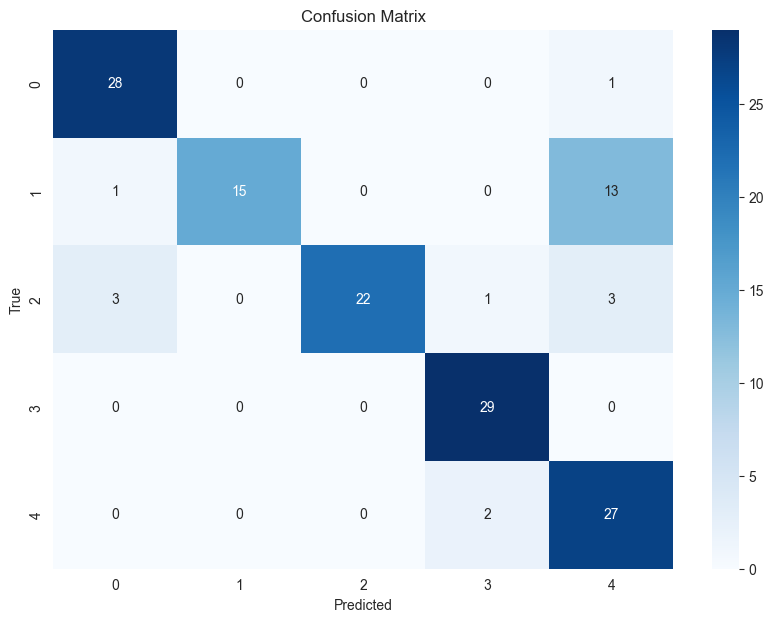

accuracy is 0.8344827586206897


100%|██████████| 9.26k/9.26k [00:01<00:00, 9.19kB/s]


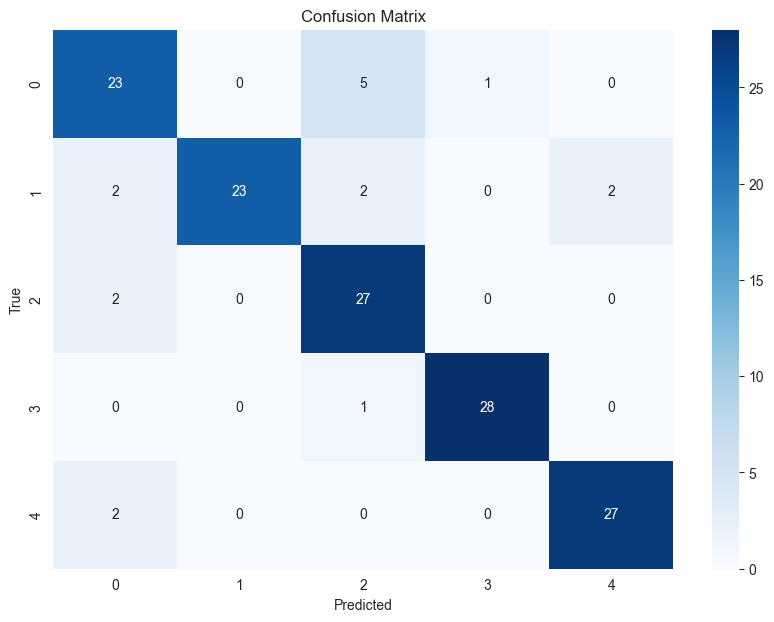

accuracy is 0.8827586206896552


100%|██████████| 9.96k/9.96k [00:01<00:00, 9.84kB/s]


In [101]:
tfidf_factor = Factorization(tfidf_extractor)
tfidf_trainer = ModelTrainer(tfidf_factor)
tfidf_trainer.train_model(plot=True)
tfidf_trainer.predict_test_data()
tfidf_trainer.submit_to_kaggle(tfidf_trainer.test_pred, 'learn-ai-bbc', 'submission.csv', 'Message')

embedding_factor = Factorization(embedding_extractor)
embedding_trainer = ModelTrainer(embedding_factor)
embedding_trainer.train_model(plot=True)
embedding_trainer.predict_test_data()
embedding_trainer.submit_to_kaggle(embedding_trainer.test_pred, 'learn-ai-bbc', 'submission.csv', 'Message')


Surprisingly, according to the result, I found that SVM are data-efficient (require a smaller amount of data to achieve similar results) even with approximately 10% of training data (145 samples, 29 samples per category), because the result of testing data indicates 0.92 and 0.93 accuracy of SVM models using different feature extractor.